In [150]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
import numpy as np
import math
import pandas
from matplotlib import pyplot as plt
from PIL import Image
import os


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [165]:
index_list = np.linspace(0,2999, 3000).astype(np.uint16)
np.random.shuffle(index_list)
index_list = index_list
print(index_list)

[1719 2941 2046 ...  572  274   21]


In [166]:
locloc = "BigDataPeople" 
namename = "\Suitman_EEVEE\\SuitMan"
all_photos = np.load(locloc + namename + 'Photos.npy')
#all_labels = np.load(locloc + namename + 'Labels.npy') # Эта штука соответствует одному из значений в all_degrees, котрое соответствует некой маске
#all_vectors = np.load(locloc + namename + 'Vectors.npy')
#all_degrees = np.load(locloc + namename + 'RotationDegrees.npy')
all_albedos = np.load(locloc + namename + 'Albedos.npy')
#all_normals = np.load(locloc + namename + 'Normals.npy')
all_masks = np.load(locloc + namename + 'Masks.npy')
# Цель просто сделать рабочий генератор маски.

In [167]:
locloc = "BigDataPeople" 
namename = "\Knight_EEVEE\\Knight"
all_photos1 = np.load(locloc + namename + 'Photos.npy')
all_albedos1 = np.load(locloc + namename + 'Albedos.npy')
all_masks1 = np.load(locloc + namename + 'Masks.npy')

In [168]:
locloc = "BigDataPeople" 
namename = "\Woman1_EEVEE\\Woman1"
all_photos2 = np.load(locloc + namename + 'Photos.npy')
all_albedos2 = np.load(locloc + namename + 'Albedos.npy')
all_masks2 = np.load(locloc + namename + 'Masks.npy')

In [169]:
all_photos = np.concatenate([all_photos, all_photos1, all_photos2], axis=0) 
all_albedos = np.concatenate([all_albedos, all_albedos1, all_albedos2], axis=0) 
all_masks = np.concatenate([all_masks, all_masks1, all_masks2], axis=0) 

In [170]:
all_photos = all_photos[index_list]
all_albedos = all_albedos[index_list]
all_masks = all_masks[index_list]
ratio = 0.96; 
all_length = round( len(all_photos) * ratio)

all_photos_test = all_photos[all_length:]
all_albedos_test = all_albedos[all_length:]
all_mask_tests = all_masks[all_length:]

all_photos = all_photos[0: all_length]
all_albedos = all_albedos[0: all_length]
all_masks = all_masks[0: all_length]

In [171]:
all_mask_tests.shape

(120, 64, 64, 3)

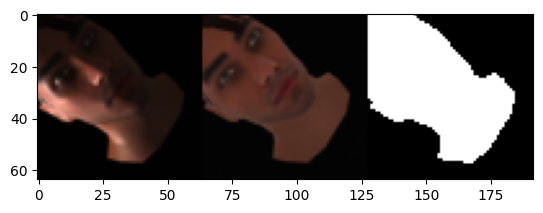

In [172]:
numberouno = 0
plt.imshow(np.concatenate([all_photos[numberouno], all_albedos[numberouno], all_masks[numberouno]], axis = 1).astype(np.float32))

In [173]:
del all_photos1; del all_albedos1 ; del all_masks1
del all_photos2; del all_albedos2 ; del all_masks2

In [174]:
def GetDifference(num_images):
    photo = all_photos[num_images]
    albedo = all_albedos[num_images]
    mask = all_masks[num_images]
    return photo - albedo * mask
def normalizeNegativeImage(imim, mask):
    nonneg = imim - np.ones(imim.shape) * imim.min()
    nmax = 0.01
    if nonneg.max() != 0:
        nmax = nonneg.max()
    nonneg = nonneg * (1.0/nmax)
    return nonneg# * mask

In [175]:
def masstestAlt(mylist, locmodel):
    inputs = all_photos[mylist]
    testanswers = all_albedos[mylist]
    imgimg = locmodel.predict([inputs])
    testanswers2 = all_albedos[mylist]
    imgimg2 = locmodel.predict([inputs])
    for i in range(len(mylist)):
        testanswers2[i] = normalizeNegativeImage(all_albedos[mylist[i]], all_masks[mylist[i]])
        imgimg2[i] = normalizeNegativeImage(imgimg[i], all_masks[mylist[i]])

    r0 =  np.concatenate(inputs, axis=1)
    r1 =  np.concatenate(testanswers, axis=1)
    r2 =  np.concatenate(imgimg, axis=1)
    r3 =  np.concatenate(testanswers2, axis=1)
    r4 =  np.concatenate(imgimg2, axis=1)
    finalimage = np.concatenate([r0, r0 - r1, r0 - r2, r3, r4], axis=0)
                                 #r3,r4, r5], 
    return finalimage

In [176]:
batch_size = 64
train_size = 1
lightjumps = 57
# Test Dataset нужно грузить отдельно

answerList = list()
print(len(all_albedos))
for i in range(len(all_albedos)):
    answerList.append(
        GetDifference(i)
    )               
all_albedos = np.array(answerList)
del answerList;

dataset = tf.data.Dataset.from_tensor_slices((all_photos, all_albedos))

dataset = dataset.shuffle(buffer_size=512, seed=13)

train_dataset = dataset.batch(64, drop_remainder=True)
print(all_photos.shape)

2880
(2880, 64, 64, 3)


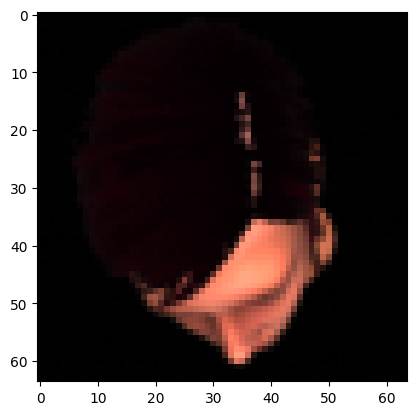

In [177]:
plt.imshow(all_photos[500].astype("float32"))

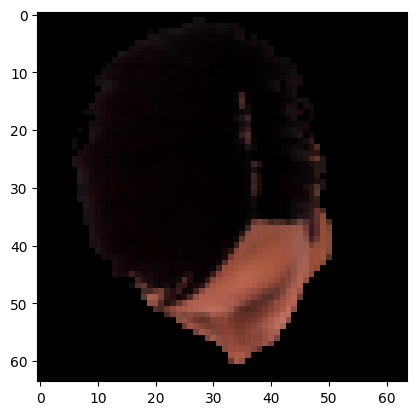

In [178]:
plt.imshow(all_photos[500].astype("float32") - all_albedos[500])

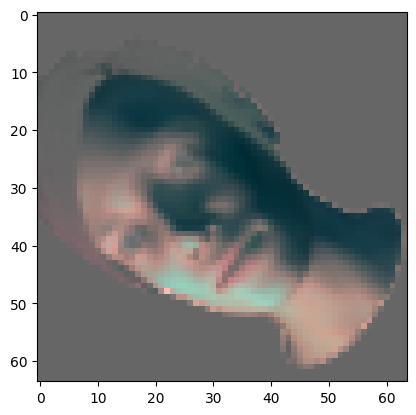

In [51]:
plt.imshow(normalizeNegativeImage(all_albedos[2500], all_masks[2500]))

In [199]:
def GiveModel():
    image_input = keras.layers.Input(shape=(64, 64, 3), name='image_input')
    x = keras.layers.Conv2D(4, (3, 3), activation='relu', padding="same")(image_input)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Conv2D(7, (3, 3), activation='relu', padding="same")(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Flatten()(x)
    
    # Полносвязный слой
    z = keras.layers.Dense(2*16*16, activation='tanh')(x)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(6*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(6*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    

    resh = keras.layers.Reshape((16, 16, 4))(do)
    anticonv1 = keras.layers.Conv2DTranspose(4, (3, 3), strides=(2,2), padding='same', activation='tanh')(resh)
    output = keras.layers.Conv2DTranspose(3, (3, 3), strides=(2,2), padding='same', activation='tanh')(anticonv1)
    
    # Создание модели
    model = keras.models.Model(inputs=[image_input], outputs=output)
    return model

In [200]:
g_optimizer_image=keras.optimizers.Adam(learning_rate=0.00008)

In [201]:
model = GiveModel()
model.compile(optimizer=g_optimizer_image, loss='mse')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 4)         112       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 4)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 7)         259       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 7)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1792)              0   

In [204]:
model.fit(train_dataset, epochs=100)

Epoch 1/100
45/45 [==============================] - 1s 17ms/step - loss: 0.0062
Epoch 2/100
45/45 [==============================] - 1s 13ms/step - loss: 0.0062
Epoch 3/100
45/45 [==============================] - 1s 13ms/step - loss: 0.0062
Epoch 4/100
45/45 [==============================] - 1s 14ms/step - loss: 0.0062
Epoch 5/100
45/45 [==============================] - 1s 13ms/step - loss: 0.0062
Epoch 6/100
45/45 [==============================] - 1s 14ms/step - loss: 0.0062
Epoch 7/100
45/45 [==============================] - 1s 13ms/step - loss: 0.0062
Epoch 8/100
45/45 [==============================] - 1s 14ms/step - loss: 0.0062
Epoch 9/100
45/45 [==============================] - 1s 13ms/step - loss: 0.0061
Epoch 10/100
45/45 [==============================] - 1s 13ms/step - loss: 0.0062
Epoch 11/100
45/45 [==============================] - 1s 13ms/step - loss: 0.0061
Epoch 12/100
45/45 [==============================] - 1s 14ms/step - loss: 0.0061
Epoch 13/100
45/45 [=====

1/1 [==============================] - 0s 22ms/step


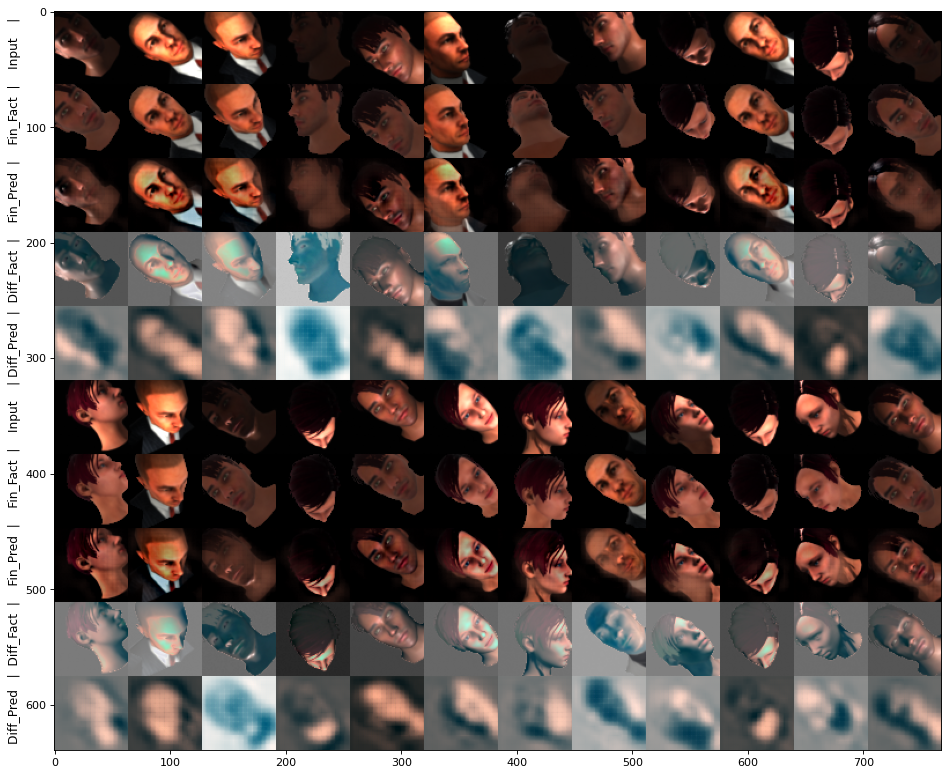

In [205]:
toinset = np.array([i * 50 for i in range(12)])
bigpicture = masstestAlt(toinset, model)
toinset1 = np.array([i * 50 + 25 for i in range(12)])
bigpicture1 = masstestAlt(toinset1, model)
bigpicture = np.concatenate([bigpicture, bigpicture1], axis=0)
plt.figure(figsize=(16, 12), dpi=80)
plt.ylabel("Diff_Pred   |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    | Diff_Pred  |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    |", fontsize=11)
plt.imshow(bigpicture.astype("float32").clip(0,1))

In [206]:
model.evaluate(all_photos_test, all_albedos_test)

4/4 [==============================] - 0s 6ms/step - loss: 0.0644


0.06435057520866394

1/1 [==============================] - 0s 176ms/step


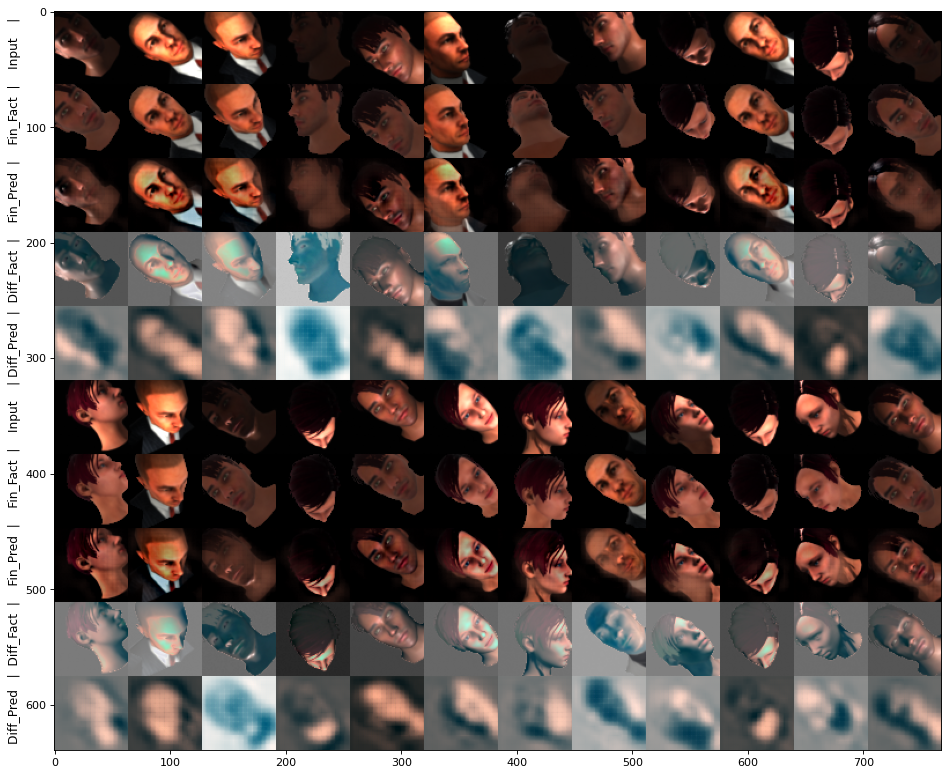

In [207]:
toinset = np.array([i for i in range(24)]); 
test_inputs = all_photos_test[toinset];  

predictions_test = model.predict(test_inputs)
test_albedos = all_albedos_test[toinset];  

actual_albedos = test_inputs - test_albedos
predicted_albedos = test_inputs -predictions_test
final_image = np.concatenate([
    np.concatenate(test_inputs[0:12], axis=1),
    np.concatenate(predictions_test[0:12], axis=1),
    np.concatenate(test_albedos[0:12], axis=1),
    np.concatenate(predicted_albedos[0:12], axis=1),
    np.concatenate(actual_albedos[0:12], axis=1),

    np.concatenate(test_inputs[12:24], axis=1),
    np.concatenate(predictions_test[12:24], axis=1),
    np.concatenate(test_albedos[12:24], axis=1),
    np.concatenate(predicted_albedos[12:24], axis=1),
    np.concatenate(actual_albedos[12:24], axis=1),
    ], axis = 0
)

plt.figure(figsize=(16, 12), dpi=80)
plt.ylabel("Diff_Pred   |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    | Diff_Pred  |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    |", fontsize=11)
plt.imshow(bigpicture.astype("float32").clip(0,1))